# Rolling Regression
Author: Thomas Wiecki

* [Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GDX).

In [2]:
%matplotlib inline
import pandas as pd
from pandas_datareader import data
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

Lets load the prices of GDX and GLD.

In [3]:
prices = data.YahooDailyReader(symbols=['GLD', 'GDX'], end='2014-8-1').read().loc['Adj Close', :, :].iloc[:1000]
prices.head()

,GDX,GLD
Date,,
2010-01-04,45.642212,109.800003
2010-01-05,46.082275,109.699997
2010-01-06,47.201568,111.510002
2010-01-07,46.971968,110.820000
2010-01-08,47.679898,111.370003


Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

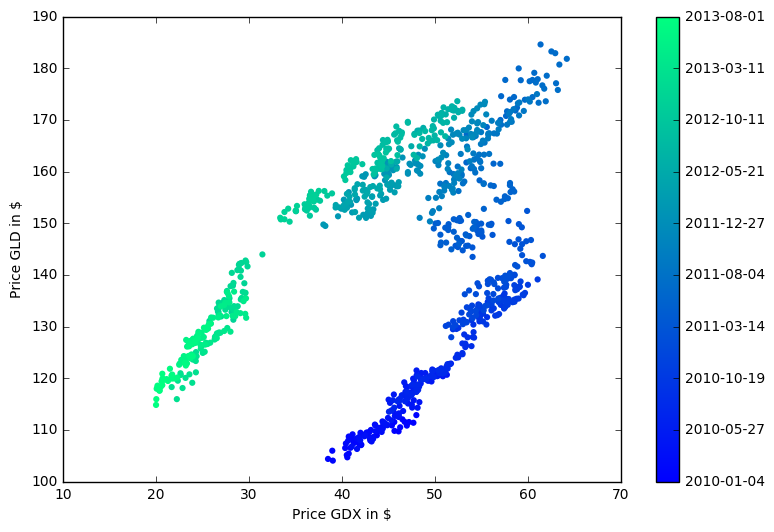

In [4]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GDX in \$', ylabel='Price GLD in \$')
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
sc = ax.scatter(prices.GDX, prices.GLD, c=colors, cmap=mymap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

A naive approach would be to estimate a linear model and ignore the time domain.

In [5]:
with pm.Model() as model_reg:
    pm.glm.glm('GLD ~ GDX', prices)
    trace_reg = pm.sample(2000)

Applied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to GDX
Assigned NUTS to sd_log_
100%|██████████| 2000/2000 [00:10<00:00, 176.25it/s]


The posterior predictive plot shows how bad the fit is.

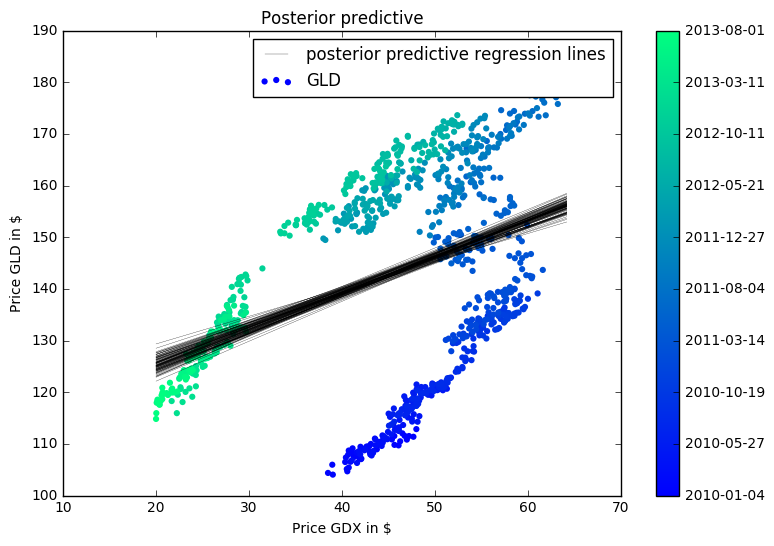

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GDX in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')
sc = ax.scatter(prices.GDX, prices.GLD, c=colors, cmap=mymap, lw=0)
pm.glm.plot_posterior_predictive(trace_reg[100:], samples=100, 
                              label='posterior predictive regression lines',
                              lm=lambda x, sample: sample['Intercept'] + sample['GDX'] * x,
                              eval=np.linspace(prices.GDX.min(), prices.GDX.max(), 100))
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the [stochastic volatility model](http://pymc-devs.github.io/pymc3/stochastic_volatility/).

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [7]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk, best sampled in log space.
    sigma_alpha = pm.Exponential('sigma_alpha', 1./.02, testval = .1)
    sigma_beta = pm.Exponential('sigma_beta', 1./.02, testval = .1)

Applied log-transform to sigma_alpha and added transformed sigma_alpha_log_ to model.
Applied log-transform to sigma_beta and added transformed sigma_beta_log_ to model.


Next, we define the regression parameters that are not a single random variable but rather a random vector with the above stated dependence structure. So as not to fit a coefficient to a single data point, we will chunk the data into bins of 50 and apply the same coefficients to all data points in a single bin.

In [8]:
import theano.tensor as T

# To make the model simpler, we will apply the same coefficient for 50 data points at a time
subsample_alpha = 50
subsample_beta = 50
with model_randomwalk:
    alpha = pm.GaussianRandomWalk('alpha', sigma_alpha**-2, 
                                  shape=len(prices) // subsample_alpha)
    beta = pm.GaussianRandomWalk('beta', sigma_beta**-2, 
                                 shape=len(prices) // subsample_beta)
    
    # Make coefficients have the same length as prices
    alpha_r = T.repeat(alpha, subsample_alpha)
    beta_r = T.repeat(beta, subsample_beta)    

Perform the regression given coefficients and data and link to the data via the likelihood.

In [9]:
with model_randomwalk:
    # Define regression
    regression = alpha_r + beta_r * prices.GDX.values
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=prices.GLD.values)

Applied interval-transform to sd and added transformed sd_interval_ to model.


Inference. Despite this being quite a complex model, NUTS handles it wells.

In [10]:
from scipy import optimize
with model_randomwalk:
    # First optimize random walk
    start = pm.find_MAP(vars=[alpha, beta], fmin=optimize.fmin_l_bfgs_b)
    
    # Sample
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(2000, step, start=start)

100%|██████████| 2000/2000 [00:58<00:00, 34.41it/s]


## Analysis of results

$\alpha$, the intercept, does not seem to change over time.

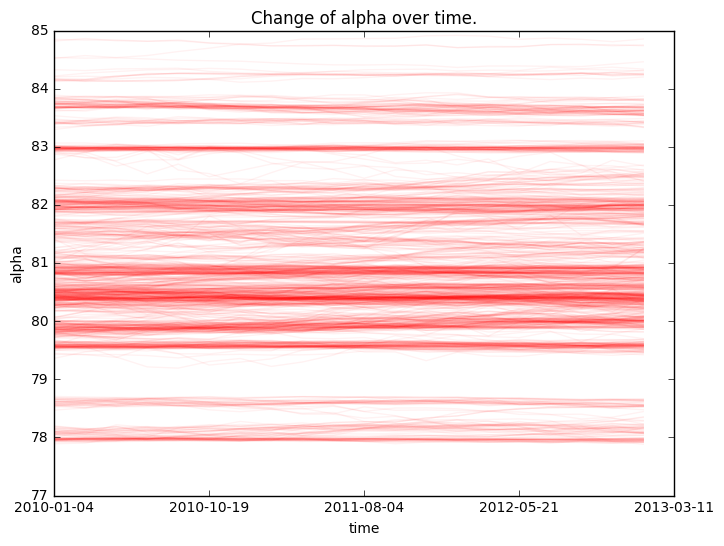

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
ax.plot(trace_rw[-1000:][alpha].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

However, the slope does.

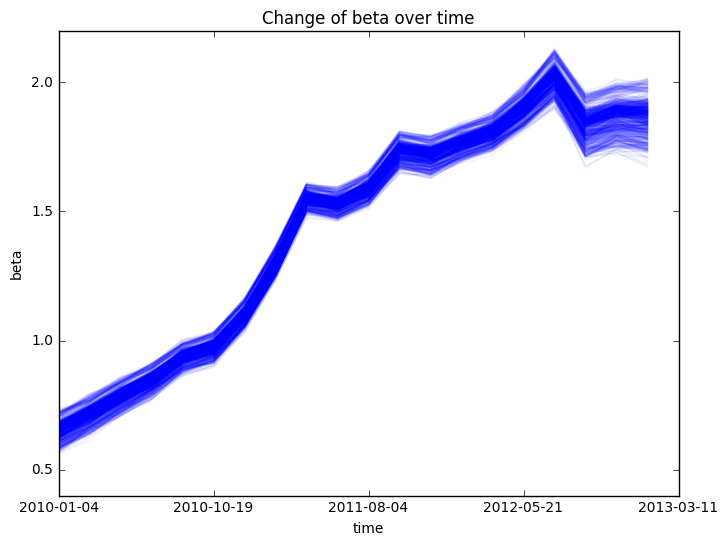

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
ax.plot(trace_rw[-1000:][beta].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

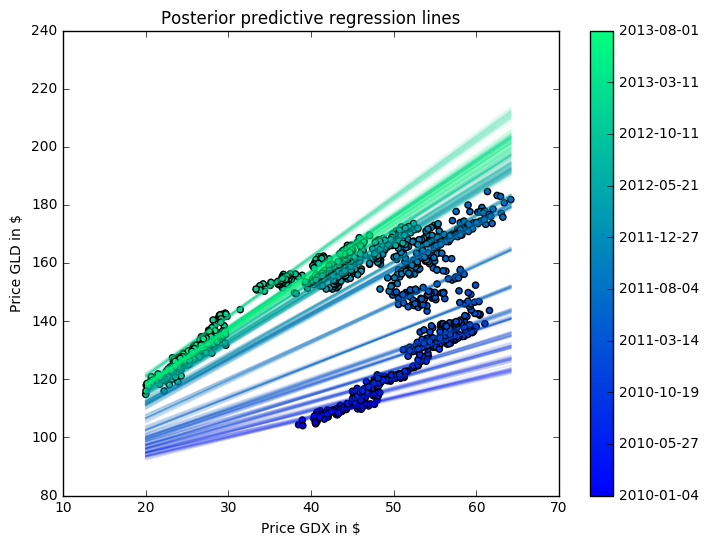

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Price GDX in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[-500::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(prices.GDX.min(), prices.GDX.max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[-500::10]['alpha'].T, trace_rw[-500::10]['beta'].T)):
    for a, b in zip(alpha, beta):
        ax.plot(xi, a + b*xi, alpha=.05, lw=1, c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices.GDX, prices.GLD, label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);